## One step approach


In [1]:
# Import
import pickle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression 
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
import pandas as pd

import mlflow
import logging 
import config 

from basic_functions import (
    get_preprocess_data,
    get_lemmatized_data,
    get_metrics
)


/Users/katharinabaumgartner/Documents/NeueFische/scripts/34_capstone/Capstone_project/backend/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Setup

In [2]:
MODEL_NAME = "logistic_regression" 
TRACKING_URI = open("../.mlflow_uri").read().strip()
EXPERIMENT_NAME = config.EXPERIMENT_NAME

logging.basicConfig(format="%(asctime)s: %(message)s") # Configure logging format to show timestamp before every message

logger = logging.getLogger()
logger.setLevel(logging.INFO) # Only show logs that are INFO or more important (e.g., WARNING, ERROR) — but ignore DEBUG.

In [3]:
DATA_PATH = "../data/data_binary_imbalanced.csv"

In [4]:
#setting the MLFlow connection and experiment
mlflow.set_tracking_uri(TRACKING_URI)
mlflow.set_experiment(EXPERIMENT_NAME)


mlflow.start_run()
run = mlflow.active_run()
print("Active run_id: {}".format(run.info.run_id))

mlflow.set_tag("model_name", MODEL_NAME)
mlflow.set_tag("mlflow.runName", "LogReg Binary Imbalanced")
mlflow.log_param("dataset", DATA_PATH)

Active run_id: 3ae879b62fca4ebb925ffd711e0d2c2d


'../data/data_binary_imbalanced.csv'

### Model Initialization

In [5]:
df = get_preprocess_data(DATA_PATH)
df = get_lemmatized_data(df)

X = df['text']
# y = df['logical_fallacies']
y = df['two_class_target']


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y)

tfidf_vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),  # Bigrams (or even trigrams)
    max_features=1000,   # Limit feature space to the most important words
    min_df=5,            # Consider words that appear in at least 5 documents
    max_df=0.9)       # Ignore words that appear in more than 90% of documents)
    
X_vectorized = tfidf_vectorizer.fit_transform(X_train)
X_vectorized_test = tfidf_vectorizer.transform(X_test)

one_model = LogisticRegression(
    penalty='l2',  # most of the solvers only work with l2
    random_state=42,
    # class_weight='balanced', 
    verbose=0, 
    n_jobs=-1, 
    )

param_grid_one = {
    # 'penalty' :['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10],
    'max_iter': [100, 500, 1000],
    'solver': ['lbfgs', 'newton-cg', 'sag', 'saga', 'liblinear']
}

cv = StratifiedKFold(5)

grid_search_one = GridSearchCV(one_model, param_grid_one, cv=cv)
grid_search_one.fit(X_vectorized, y_train)

best_params_one = grid_search_one.best_params_
print(best_params_one)

# log params for binary model
for k,v in best_params_one.items():
    mlflow.log_param(f"best_param_{k}", v)

best_model_one = grid_search_one.best_estimator_
y_train_pred_one = best_model_one.predict(X_vectorized)
y_test_pred_one = best_model_one.predict(X_vectorized_test)

/Users/katharinabaumgartner/Documents/NeueFische/scripts/34_capstone/Capstone_project/backend/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/katharinabaumgartner/Documents/NeueFische/scripts/34_capstone/Capstone_project/backend/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/katharinabaumgartner/Documents/NeueFische/scripts/34_capstone/Capstone_project/backend/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/katharinabaumgartner/Documents/NeueFische/scripts/34_capstone/Capstone_project/backend/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached 

{'C': 1, 'max_iter': 100, 'solver': 'lbfgs'}


/Users/katharinabaumgartner/Documents/NeueFische/scripts/34_capstone/Capstone_project/backend/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/katharinabaumgartner/Documents/NeueFische/scripts/34_capstone/Capstone_project/backend/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/katharinabaumgartner/Documents/NeueFische/scripts/34_capstone/Capstone_project/backend/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(
/Users/katharinabaumgartner/Documents/NeueFische/scripts/34_capstone/Capstone_project/backend/.venv/lib/python3.11/site-pack

In [6]:
with open('../models/logreg_binary_imbalanced/logreg_binary_imbalanced.pkl', 'wb') as f:
    pickle.dump(best_model_one, f)

### Evaluation

In [7]:
def log_metrics(cr, split):
    for key, value in cr.items():
        if (key == "accuracy"):
                # print(f"{split}_{key}", round(value,2))
                mlflow.log_metric(f"{split}_{key}", value)
        else:
            for metric in value:
                mlflow.log_metric(f"{split}_{key}_{metric}", value.get(metric))
                # print(f"{split}_{key}_{metric}", round(value.get(metric),2))

2025-04-15 13:29:27,232: get train metrics for one-step approach
2025-04-15 13:29:27,235: classification_report
2025-04-15 13:29:27,407: confusion_matrix
2025-04-15 13:29:27,415: heatmap


              precision    recall  f1-score   support

     fallacy       0.92      0.25      0.39       700
        none       0.87      1.00      0.93      3617

    accuracy                           0.87      4317
   macro avg       0.90      0.62      0.66      4317
weighted avg       0.88      0.87      0.84      4317

[[ 175  525]
 [  15 3602]]


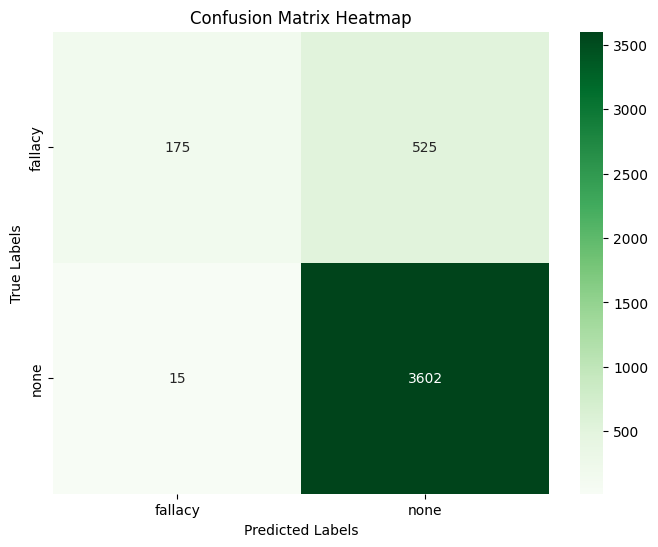

In [8]:
logger.info('get train metrics for one-step approach')
classification_report_one_train = get_metrics(y_train, y_train_pred_one)
log_metrics(classification_report_one_train, 'train')

2025-04-15 13:29:33,397: get test metrics for one-step approach
2025-04-15 13:29:33,400: classification_report
2025-04-15 13:29:33,566: confusion_matrix
2025-04-15 13:29:33,570: heatmap


              precision    recall  f1-score   support

     fallacy       0.74      0.21      0.32       300
        none       0.87      0.99      0.92      1551

    accuracy                           0.86      1851
   macro avg       0.80      0.60      0.62      1851
weighted avg       0.84      0.86      0.82      1851

[[  62  238]
 [  22 1529]]


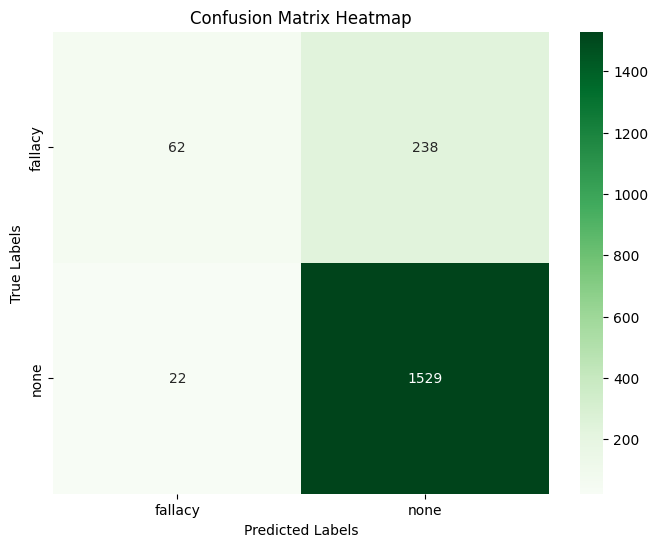

In [9]:
logger.info('get test metrics for one-step approach')
classification_report_one_test = get_metrics(y_test, y_test_pred_one)
log_metrics(classification_report_one_test, 'test')

In [10]:
mlflow.end_run()

🏃 View run LogReg Binary Imbalanced at: http://127.0.0.1:5001/#/experiments/118053630762497624/runs/3ae879b62fca4ebb925ffd711e0d2c2d
🧪 View experiment at: http://127.0.0.1:5001/#/experiments/118053630762497624
